# Drag from Tides

This adds a constant time lag model (Hut 1981) to tides raised on either the primary and/or the orbiting bodies.
As an example, we'll add the tides raised on a post-main sequence Sun near its tip-RGB phase by the Earth.

For a more advanced example implementation that includes stellar evolution using ["Parameter Interpolation"](https://reboundx.readthedocs.io/en/latest/effects.html#parameter-interpolation) and extended integration of terrestrial-like planets, see §4.2 and Fig. 5 of [Baronett et al. (2021)](https://arxiv.org/abs/2101.12277) and https://github.com/sabaronett/REBOUNDxPaper.

In [1]:
import rebound
import reboundx
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

def getsim():
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun') 
    sim.add(m=0.86)        # post-MS Sun
    sim.add(m=3.e-6, a=1., e=0.03) # Earth
    sim.move_to_com()
    rebx = reboundx.Extras(sim)
    tides = rebx.load_force("tides_constant_time_lag")
    rebx.add_force(tides)

    return sim, rebx, tides

We specify the primary and secondaries' equilibrium gravitational response to the tidal field acting on them through the `tctl_k2` potential Love number of degree 2. If we additionally give the primary a physical radius, then any (massive) orbiting body will raise equilibrium tides on the primary. Similarly, if we add a physical radius and `tctl_k2` to any of the orbiting bodies, the primary will raise tides on that particle (but note that orbiting bodies will not raise tides on one another):

In [2]:
sim, rebx, tides = getsim()
ps = sim.particles
ps[0].r = 0.85 # AU
ps[0].params["tctl_k2"] = 0.03

If we stop here and don't add a time lag, we will get the instantaneous equilibrium tide, which provides a conservative, radial non-Keplerian potential. The total energy will be conserved, but the pericenter will precess. 

In [3]:
H0 = sim.energy() + rebx.tides_constant_time_lag_potential()
tmax = 5000
Nout=1000

pomega, Eerr = np.zeros(Nout), np.zeros(Nout)
times = np.linspace(0,tmax,Nout)

for i, time in enumerate(times):
    sim.integrate(time)
    pomega[i] = ps[1].pomega
    H = sim.energy() + rebx.tides_constant_time_lag_potential()
    Eerr[i] = abs((H-H0)/H0)

Text(0, 0.5, 'Energy Error')

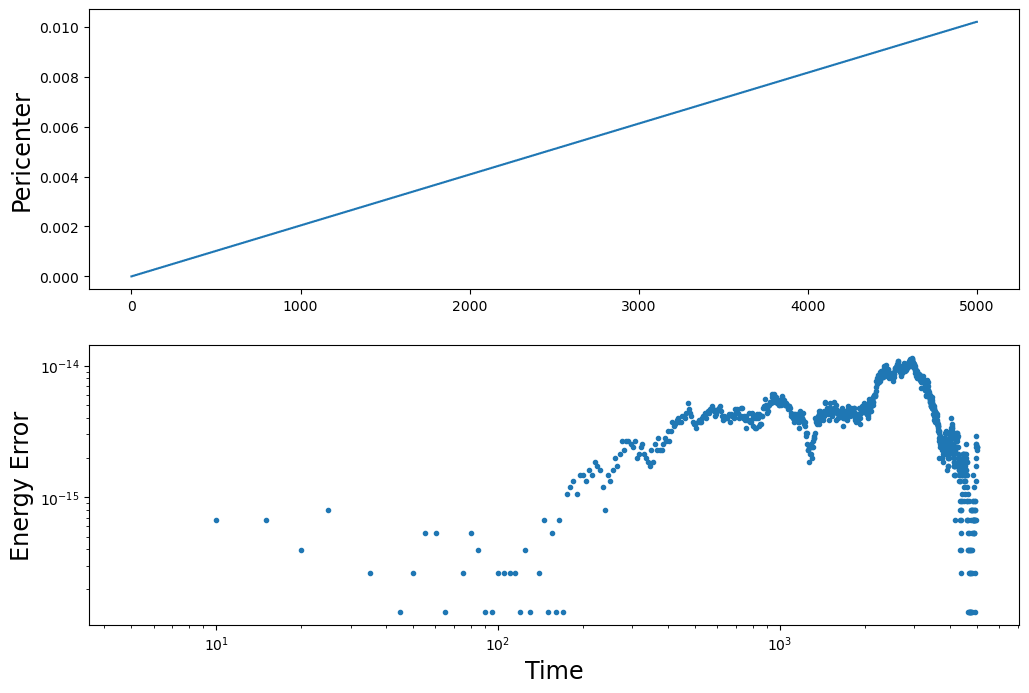

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axarr = plt.subplots(nrows=2, figsize=(12,8))
axarr[0].plot(times, pomega)
axarr[0].set_ylabel("Pericenter", fontsize='xx-large')
axarr[1].plot(times, Eerr, '.')
axarr[1].set_xscale('log')
axarr[1].set_yscale('log')
axarr[1].set_xlabel('Time', fontsize='xx-large')
axarr[1].set_ylabel('Energy Error', fontsize='xx-large')

## Constant Time Lag

If we additionally set the `tctl_tau` constant time lag parameter, this delayed response introduces dissipation, which will typically cause eccentricity damping, and will migrate the orbiting bodies either inward or outward depending on whether they orbit faster or slower than the spin of the tidally deformed body. We set the spin rate of each body with the `Omega` parameter. If it is not set, `Omega` is assumed to be zero.

We note that this implementation assumes bodies' spins are fixed, so consider whether more angular momentum is being changed in the system than is available in the spins! We additionally assume that bodies spins are aligned with the reference z axis. 

As an example, for a highly-evolved RGB Sun, tidal friction in the outer convective envelope will retard tidal bulges on the solar photosphere ([Schröder & Smith 2008](https://doi.org/10.1111/j.1365-2966.2008.13022.x)), resulting in a non-zero constant time lag.
From Eq. 8 of [Baronett et al. (2021)](https://arxiv.org/abs/2101.12277),

$$
\tau = \dfrac{2R^3}{GMt_f},
$$

where $\tau$ is the constant time lag parameter (`tctl_tau`),
$R$ and $M$ are the physical radius and mass of the tidally deformed body respectively,
$G$ is the gravitational constant, and
$t_f(t) = (M(t)R(t)^2/L(t))^{1/3} \approx \mathcal{O}(1 \textrm{yr}$) is the convective friction time ([Zahn 1989](https://ui.adsabs.harvard.edu/abs/1989A%26A...220..112Z/abstract), Eq. 7).
For this simulation's values (i.e., $R = 0.85\,\text{au}$, $G = 4\pi^2\,\text{au}^3\cdot\text{yr}^{-2}\cdot M_\odot^{-1}$, $M = 0.86\,M_\odot$, and $t_f = 1\,\text{yr}$),

$$
\tau \approx 0.04\,\text{yr}.
$$

In [5]:
sim, rebx, tides = getsim()
ps = sim.particles
ps[0].r = 0.85 # AU
ps[0].params["tctl_k2"] = 0.03
ps[0].params["tctl_tau"] = 0.04
ps[0].params["Omega"] = [0,0,0] # explicitly set to 0 (would be 0 by default)

We can compare our numerical integration to the theoretical prediction assuming a circular orbit (see Baronett et al. 2021, Eq. 7). We'll integrate for 250 kyr and store the Earth's semi-major axis and eccentricity.

In [6]:
import numpy as np
tmax = 2.5e5
Nout=1000

a, e = np.zeros(Nout), np.zeros(Nout)
times = np.linspace(0,tmax,Nout)
# to plot physical radius of the Sun
R0 = 0*times + ps[0].r

q = (ps[1].m/ps[0].m)
T = ps[0].r**3/sim.G/ps[0].m/ps[0].params["tctl_tau"]
apred = ps[0].r*((ps[1].a/ps[0].r)**8 - 48.*ps[0].params["tctl_k2"]*q*(1+q)*times/T)**(1./8.)

In [7]:
%%time
for i, time in enumerate(times):
    sim.integrate(time)
    a[i] = ps[1].a
    e[i] = ps[1].e

CPU times: user 48.6 s, sys: 287 ms, total: 48.9 s
Wall time: 48.9 s


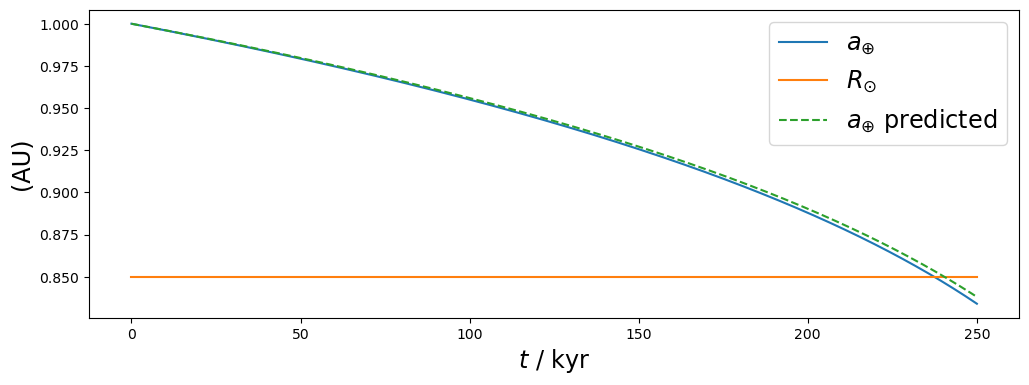

In [8]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(times/1e3, a, label='$a_{\oplus}$')
ax.plot(times/1e3, R0, label='$R_{\odot}$')
ax.plot(times/1e3, apred, '--', label='$a_{\oplus}$ predicted')
ax.set_xlabel('$t$ / kyr', fontsize='xx-large')
ax.set_ylabel('(AU)', fontsize='xx-large')
ax.legend(fontsize='xx-large', loc='best')

Note the small eccentricity we originally initialized for the Earth causes our numerical result to diverge only slightly from the circular, theoretical prediction.
In fact, we can also check that the eccentricity decays:

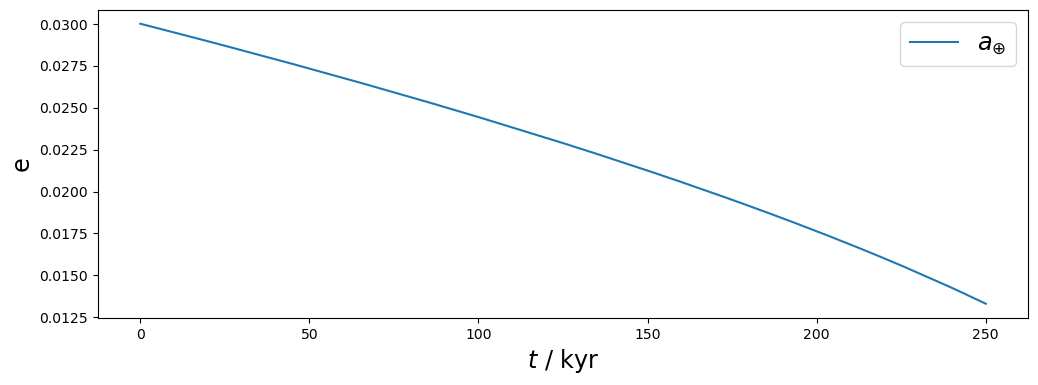

In [9]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(times/1e3, e, label='$a_{\oplus}$')
ax.set_xlabel('$t$ / kyr', fontsize='xx-large')
ax.set_ylabel('e', fontsize='xx-large')
ax.legend(fontsize='xx-large', loc='best')